In [ ]:
# This is to generate a exponential heating curve and show how 
# to extract the coefficients of the differential equation:
# dv/dt = (v + c)*d
# using the SG-filter to extract the derivative from a sampled value

In [1]:
import pandas, numpy

# this turns out to be the Savitzky-Golay filter
sec1 = pandas.Timedelta(seconds=1)
def intercurvefitdifferentiate(seriestimeindex, rx, ws, deg=3):
    rx0 = pandas.Series(0, seriestimeindex)
    rx1 = pandas.Series(0, seriestimeindex)
    rx2 = pandas.Series(0, seriestimeindex)
    wt = ws*sec1
    wt2 = ws*2*sec1
    wt4 = ws*4*sec1
    for n in range(len(seriestimeindex)):
        t = seriestimeindex[n]
        lx = rx[t-wt:t+wt]
        if len(lx) <= 3:
            lx = rx[t-wt2:t+wt2]
            if len(lx) <= 3:
                lx = rx[t-wt4:t+wt4]
                if len(lx) <= 3:
                    #print(t)
                    continue
        ts = (lx.index - t)/sec1
        weights = 1/((abs(ts)/ws)**2+1)
        pm = numpy.polyfit(ts, lx, deg=deg, w=weights)
        rx0.iloc[n] = numpy.polyval(pm, 0)
        pm1 = numpy.polyder(pm)
        rx1.iloc[n] = numpy.polyval(pm1, 0)
        pm2 = numpy.polyder(pm, 2)
        rx2.iloc[n] = numpy.polyval(pm2, 0)
    return rx0, rx1, rx2

def curvefitdifferentiate(rx, ws, deg=3):
    return intercurvefitdifferentiate(rx.index, rx, ws, deg=3)


# this needs to calculate the actual delay sequence factor from the half-life value
def ExpFilter(vseries, rE):  # rE = -math.log(0.5)/(half-life in seconds)
    dt = vseries.index.to_series().diff().mean().value*1e-9
    lam = 1 - math.exp(-dt*rE)
    v0 = vseries.iloc[0]
    return pandas.Series(scipy.signal.lfilter((lam, 0), (1, lam-1), vseries, zi=(v0*(1-lam),))[0], vseries.index)

# as above but takes each step individually rather than by average step
def AccurateExpFilterInPlace(vseries, rE):  # rE = -math.log(0.5)/(half-life in seconds)
    for i in range(1, len(vseries)):
        dt = (vseries.index[i] - vseries.index[i-1]).microseconds*1e-6
        vseries[i] += (vseries[i-1] - vseries[i])*math.exp(-dt*rE) 

# very important function for quickly aligning timseries (sometimes you filter slightly before if there are oscillations)
def InterpT(seriestime, seriesother, dts=0):
    vals = numpy.interp(seriestime.index.asi8, seriesother.index.asi8+int(dts*1e9), seriesother)
    return pandas.Series(vals, seriestime.index)
    
def TimeOfClosestPoint(pQ, x, y):
    return ((pQ.x-x)**2 + (pQ.y+y)**2).idxmin()


In [4]:

pandas.Timestamp.now()


pandas.Timedelta()


Timestamp('2021-09-27 11:02:08.744896')

In [210]:
numpy.random.normal(0, 0.1)

<module 'numpy.random' from '/nix/store/x9s5ydfw01k3dpm9bw1jm4xcbmj5j0zc-python3.9-numpy-1.21.2/lib/python3.9/site-packages/numpy/random/__init__.py'>

In [213]:
# make a timeseries with some noise added and points discarded
timespacing = 0.1
tlength = 10.0
tnoisevar = timespacing*0.2
tnoiselimdrop = min(tnoisevar*2, timespacing/2)

t0 = pandas.Timestamp.now()

nsamples = int(tlength/timespacing)
tdither = [ numpy.random.exponential(tnoisevar)*numpy.random.choice([-1,1])  for i in range(nsamples) ]

dts = [ (i*timespacing+rt)*sec1  for i, rt in zip(range(nsamples), tdither)  if abs(rt) <= tnoiselimdrop ]
dts = pandas.Index(dts)
ts = t0 + dts

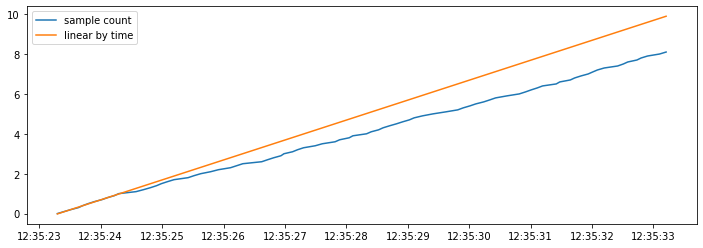

In [153]:
linearvalues = pandas.Series((ts-t0)/sec1, ts)
indexvalues = pandas.Series(range(len(ts)), ts)*timespacing
plt.figure(figsize=(12,4))
plt.plot(indexvalues, label="sample count")
plt.plot(linearvalues, label="linear by time")
plt.legend()

Text(0.5, 1.0, 'heating curve exp=0.560000')

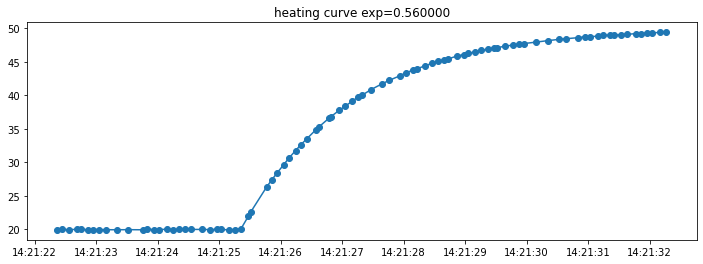

In [221]:
v0 = 20
v1 = 50
timebreak = 3.0
expcoefficient = 0.56
vnoisestd = 0.03

ve = numpy.exp(expcoefficient*numpy.minimum(timebreak-dts.values/sec1, 0.0))
vdither = numpy.array([ numpy.random.normal(0, vnoisestd)  for i in range(len(ve)) ])
v = ve*(v0-v1) + v1 + vdither


expvalues = pandas.Series(v, ts)
plt.figure(figsize=(12,4))
plt.plot(expvalues)
plt.scatter(expvalues.index, expvalues)
plt.title("heating curve exp=%f" % expcoefficient)

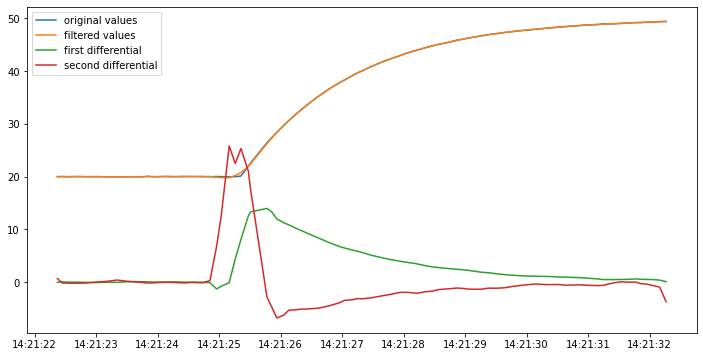

In [222]:
ws = 0.4  # window width in seconds 
drx0, drx1, drx2 = curvefitdifferentiate(expvalues, 0.6)
plt.figure(figsize=(12,6))
plt.plot(expvalues, label="original values")
plt.plot(drx0, label="filtered values")
plt.plot(drx1, label="first differential")
plt.plot(drx2, label="second differential")
plt.legend()

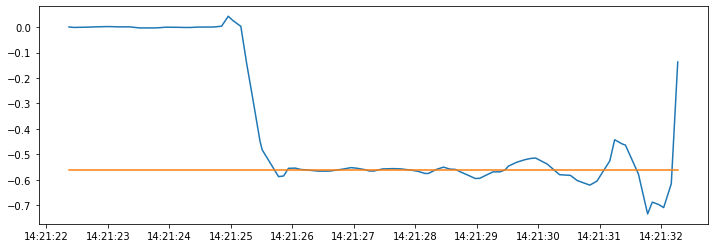

In [223]:
plt.figure(figsize=(12,4))
plt.plot(drx1/(drx0-50))
plt.plot(drx1.index, [-expcoefficient]*len(drx1))


In [224]:
import scipy.optimize
scipy.optimize.minimize

cleantimebreak = timebreak+1.0  # if this isn't clear of the gap it swamps it

ctb = t0 + cleantimebreak*sec1
purevd0 = drx0[ctb:]
purevd1 = drx1[ctb:]

# minimize: vd1 - (vd0 + X[0])*X[1]
def fun(X):
    y = purevd1 - (purevd0 + X[0])*X[1]
    return sum(y**2)

fun([-50,-0.56])


0.3389688080855444

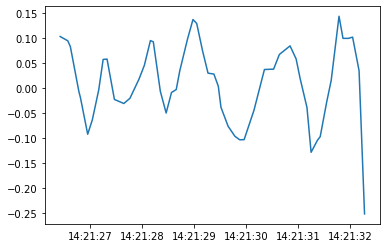

In [225]:
X = [-50,-0.56]
y = purevd1 - (purevd0 + X[0])*X[1]
plt.plot(y)

In [226]:
# proof we can get to the solution from fairly close
scipy.optimize.minimize(fun, [-40,-0.7])

      fun: 0.327919672535535
 hess_inv: array([[ 0.06590286, -0.0041742 ],
       [-0.0041742 ,  0.00047861]])
      jac: array([2.50712037e-06, 2.16066837e-07])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([-49.9982093 ,  -0.56228638])

In [227]:
# but you can't go too far
scipy.optimize.minimize(fun, [-40,-0.9])

      fun: 326.19078324637604
 hess_inv: array([[ 5.58757794e-03, -6.21806739e-11],
       [-6.21806739e-11,  2.63976582e-11]])
      jac: array([ 0.00000000e+00, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 615
      nit: 121
     njev: 205
   status: 0
  success: True
        x: array([1.88594255e+04, 1.47493164e-04])